In [153]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
yf.pdr_override()
import datetime as dt

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Datetime'>

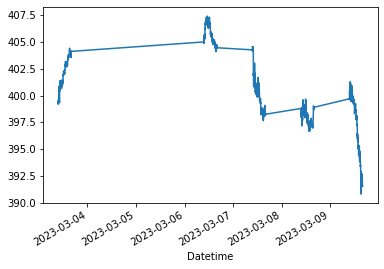

In [154]:
start = dt.datetime.now() - dt.timedelta(7)
end = dt.datetime.now()
dfe = yf.download('SPY', start=start, end=end, interval='1m')
dfe['Close'].plot()

<AxesSubplot:xlabel='Datetime'>

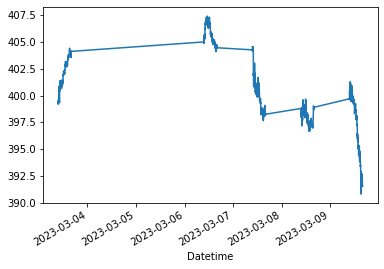

In [155]:
dfe['Adj Close'].plot()

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:xlabel='Datetime'>

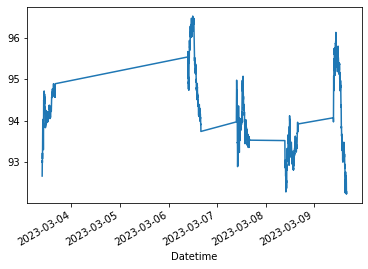

In [156]:
start = dt.datetime.now() - dt.timedelta(7)
end = dt.datetime.now()
dff = yf.download('SPY, AMZN', interval='1m', start=start, end=end)
dff['Adj Close']['AMZN'].plot()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

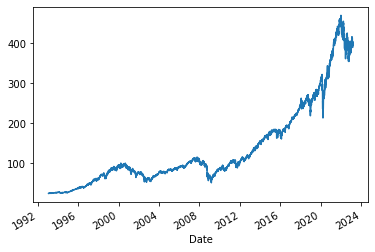

In [157]:
df = yf.download('SPY')
spy = df['Adj Close']
spy.plot()

<AxesSubplot:xlabel='Date'>

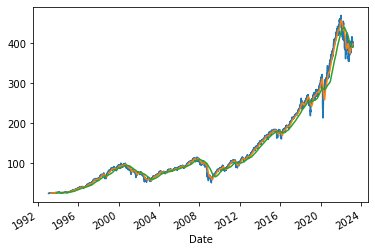

In [158]:
ma1 = spy.rolling(50).mean() #compute 50 day MA
ma2 = spy.rolling(200).mean() #compute 200 day MA

spy.plot()
ma1.plot()
ma2.plot()

<AxesSubplot:xlabel='Date'>

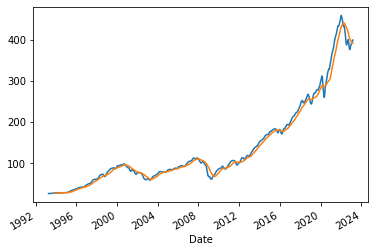

In [159]:
ma1.plot()
ma2.plot()

In [160]:
entry = None
pnls = []
for i in range(len(spy)):
    if (ma1.iloc[i]-ma2.iloc[i])>0 and (ma1.iloc[i-1]-ma2.iloc[i-1])<0:
        if entry:
            pnl = entry - spy.iloc[i]
        
        entry = spy.iloc[i]
        print('enter long', pnl)
    
    elif (ma1.iloc[i]-ma2.iloc[i])<0 and (ma1.iloc[i-1]-ma2.iloc[i-1])>0:
        if entry: 
            pnl = spy.iloc[i] - entry
        
        entry = spy.iloc[i]
        print('enter short', pnl)

enter short 185.58821868896484
enter long -1.6097869873046875
enter short 35.558122634887695
enter long -12.641319274902344
enter short 17.717193603515625
enter long 18.287574768066406
enter short -1.3317489624023438
enter long 9.68798828125
enter short 12.576194763183594
enter long -1.5689926147460938
enter short 12.674949645996094
enter long -2.8387603759765625
enter short 15.1624755859375
enter long 38.87272644042969
enter short 12.702911376953125
enter long -9.796806335449219
enter short 2.7715911865234375
enter long -10.811561584472656
enter short 63.57239532470703
enter long -9.467132568359375
enter short -14.384902954101562
enter long -20.608306884765625
enter short 60.716644287109375
enter long -17.251495361328125
enter short -17.011672973632812
enter long -58.20027160644531
enter short 123.31027221679688
enter long 23.91558837890625


In [161]:
entry = None
pnls = []
dates = []

for i in range(len(spy)):
    if (ma1.iloc[i]-ma2.iloc[i])>0 and (ma1.iloc[i-1]-ma2.iloc[i-1])<0:
        if entry:
            pnl = (entry - spy.iloc[i])/entry
            pnls.append(pnl)
            dates.append(spy.index[i])
        
        entry = spy.iloc[i]
    
    elif (ma1.iloc[i]-ma2.iloc[i])<0 and (ma1.iloc[i-1]-ma2.iloc[i-1])>0:
        if entry: 
            pnl = (spy.iloc[i] - entry)/entry
            pnls.append(pnl)
            dates.append(spy.index[i])
         
        entry = spy.iloc[i]

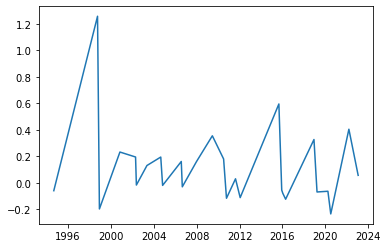

In [162]:
plt.plot(dates, pnls)

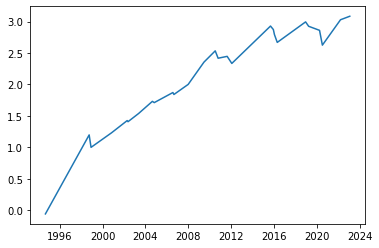

In [163]:
plt.plot(dates, np.cumsum(pnls))

In [164]:
np.prod(1+np.array(pnls))

8.659871598643534

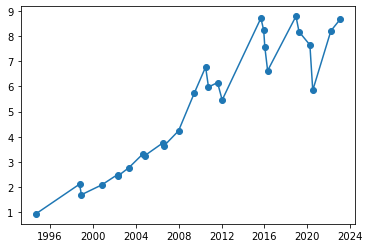

In [165]:
plt.plot(dates, np.cumprod(1+np.array(pnls)),'-o')

In [166]:
np.std(pnls)

0.29621470556804463

In [167]:
entry = None
pnls = []
dates = []
unrlzd = []
unrlzd_dates = []
inpos = 0

hold_times = []
COMMS = 0.005

for i in range(len(spy)):
    unr = ((spy.iloc[i]-spy.iloc[i-1])/spy.iloc[i-1])*inpos
    unrlzd.append(unr)
    unrlzd_dates.append(spy.index[i])
    
    if (ma1.iloc[i]-ma2.iloc[i])>0 and (ma1.iloc[i-1]-ma2.iloc[i-1])<0:
        if entry:
            pnl = (entry - spy.iloc[i])/entry - COMMS
            pnls.append(pnl)
            dates.append(spy.index[i]) 
            hold_times.append((spy.index[i]-start).total_seconds())
        
        entry = spy.iloc[i]
        inpos = 1
        start = spy.index[i]
        unrlzd[-1] -= COMMS/2
    
    elif (ma1.iloc[i]-ma2.iloc[i])<0 and (ma1.iloc[i-1]-ma2.iloc[i-1])>0:
        if entry: 
            pnl = (spy.iloc[i] - entry)/entry
            pnls.append(pnl)
            dates.append(spy.index[i])
            hold_times.append((spy.index[i]-start).total_seconds())
         
        entry = spy.iloc[i]
        inpos = -1
        start = spy.index[i]
        unrlzd[-1] -= COMMS/2

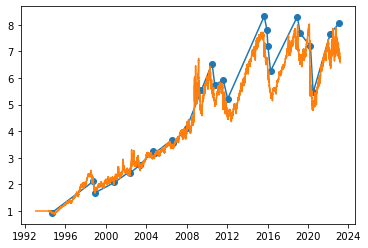

In [168]:
plt.plot(dates, np.cumprod(1+np.array(pnls)),'-o')
plt.plot(unrlzd_dates, np.cumprod(1+np.array(unrlzd)))

In [169]:
volar = (np.mean(unrlzd)/np.std(unrlzd))*np.sqrt(252)
volar

0.4270430604187788

In [170]:
np.mean(pnls) - 0.002

0.1096216776089089

In [171]:
hold_days = np.array(hold_times)/86400
np.mean(hold_days)

388.85339506172835

In [172]:
df_rets = pd.DataFrame(unrlzd, index=unrlzd_dates)
df_pnl = (1+df_rets).cumprod()

<AxesSubplot:>

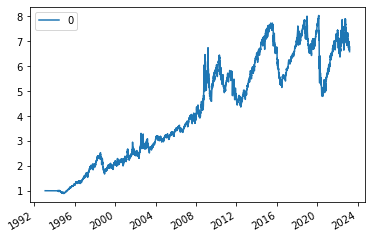

In [173]:
df_pnl.plot()

<AxesSubplot:>

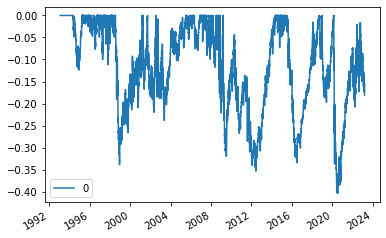

In [174]:
(df_pnl/df_pnl.expanding().max()-1).plot() #drawdown curve; 40% max drawdown

In [187]:
beta = np.corrcoef(spy.pct_change().iloc[2:], df_rets[0].iloc[2:])[0,1]
beta

0.02939763328939294

In [175]:
entry = None
pnls = []
dates = []
unrlzd = []
unrlzd_dates = []
inpos = 0

for i in range(len(spy)):
    unr = ((spy.iloc[i]-spy.iloc[i-1]))*inpos
    unrlzd.append(unr)
    unrlzd_dates.append(spy.index[i])
    
    if (ma1.iloc[i]-ma2.iloc[i])>0 and (ma1.iloc[i-1]-ma2.iloc[i-1])<0:
        if entry:
            pnl = (entry - spy.iloc[i])
            pnls.append(pnl)
            dates.append(spy.index[i]) 
        
        entry = spy.iloc[i]
        inpos = 1
    
    elif (ma1.iloc[i]-ma2.iloc[i])<0 and (ma1.iloc[i-1]-ma2.iloc[i-1])>0:
        if entry: 
            pnl = (spy.iloc[i] - entry)
            pnls.append(pnl)
            dates.append(spy.index[i])
         
        entry = spy.iloc[i]
        inpos = -1

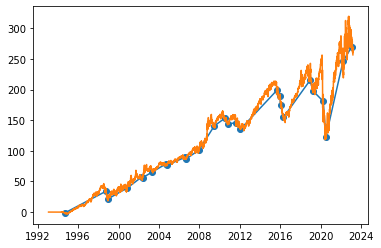

In [176]:
plt.plot(dates, np.cumsum(np.array(pnls)),'-o')
plt.plot(unrlzd_dates, np.cumsum(np.array(unrlzd)))

In [177]:
import talib

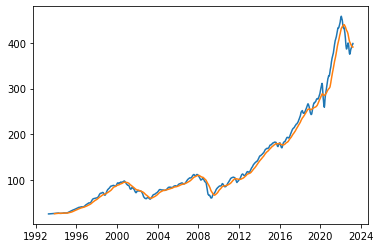

In [178]:
ma50 = talib.SMA(spy,50)
ma200 = talib.SMA(spy,200)
plt.plot(ma50)
plt.plot(ma200)

In [179]:
dir(talib)

['ACOS',
 'AD',
 'ADD',
 'ADOSC',
 'ADX',
 'ADXR',
 'APO',
 'AROON',
 'AROONOSC',
 'ASIN',
 'ATAN',
 'ATR',
 'AVGPRICE',
 'BBANDS',
 'BETA',
 'BOP',
 'CCI',
 'CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CD

<AxesSubplot:xlabel='Date'>

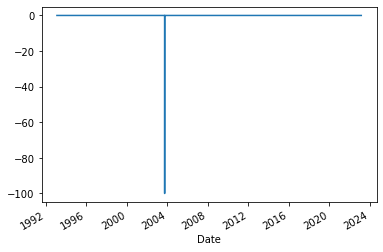

In [180]:
crows = talib.CDL3BLACKCROWS(df.Open, df.High, df.Low, df.Close)
crows.plot()